# Imports

In [1]:
from importlib import reload
import os
import pickle as pkl

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
import dplyr_lite as d
import models_pyt as mo
import ngram_analysis as nga
import red_flag_blue_flag as rfbf
import text_utils as tu

# Prepare Inputs

In [4]:
model_info_dir = 'model_info/'
get_model_info_f = lambda f: os.path.join(model_info_dir, f)

def load_model_info_pkl(name):
    with open(get_model_info_f(f'{name}.pkl'), 'rb') as f:
        ret = pkl.load(f)
    return ret

In [5]:
abstracts = pd.read_csv('content/pubmed_cr_hep_ctl_abstracts_clean.csv')

In [6]:
split_ixs_lookup =load_model_info_pkl('ixs_lookup')
vocab = load_model_info_pkl('vocab')

In [7]:
seq_len = 400

In [8]:
scan_cnn_1L = mo.ScanCnn1Logit(sequence_length=seq_len, n_terms=len(vocab.vocab) + 1).eval()

In [9]:
scan_cnn_1L.load_state_dict(torch.load(get_model_info_f('state_dict.pt')))

<All keys matched successfully>

In [10]:
logit_extract = mo.CnnLogitExtracts(scan_cnn_1L, seq_length=seq_len)

In [13]:
dataset_lookup = {
    k: tu.TextDataset(abstracts.iloc[ixs,: ], vocab, sample_len=seq_len)
    for k, ixs in split_ixs_lookup.items()
}

In [14]:
dataset_lookup

{'train': <text_utils.TextDataset at 0x7fc7cccfd880>,
 'val': <text_utils.TextDataset at 0x7fc7cbddfb20>,
 'holdout': <text_utils.TextDataset at 0x7fc7cbddfdc0>}

In [15]:
num_decode = {v: k for k, v in vocab.numericizer.items()}

In [16]:
num_decode_fn = lambda nums: [num_decode.get(n, 'UNK') for n in nums]

In [17]:
dataset_lookup['train'][10][0][:20][[4, 7]]

array([ 602, 5093])

In [18]:
' '.join(num_decode_fn(dataset_lookup['train'][10][0][:20]))

'a case of rectal gastrointestinal stromal tumor gist treated with imatinib mesylate neoadjuvant therapy to preserve the anus </s> </s>'

# Filter Activations

In [20]:
get_sample_activ, loc_term_lo = nga.get_sample_activations_gen(
    scan_cnn_1L, logit_extract, dataset_lookup['holdout'], num_decode_fn
)

In [21]:
get_sample_activ(1)[0]

/home/jod204/anaconda3/envs/jd_pyt_pip_keras_fastai/lib/python3.9/site-packages/torch/nn/functional.py:627: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


,activ,location,ngram,net_weight,net_logit,k
0,1.550516,53,"(includes,)",-0.074366,-0.115306,1
1,1.842361,136,"(which,)",-0.062811,-0.115721,1
2,1.124920,103,"(13,)",0.057013,0.064135,1
3,1.976160,37,"(differentiation,)",-0.087916,-0.173737,1
4,1.307891,150,"(period,)",0.062623,0.081904,1
...,...,...,...,...,...,...
139,1.620546,114,"(UNK, of, the, right, kidney)",-0.060757,-0.098459,5
140,1.711044,139,"(reported, in, the, literature, </s>)",-0.051564,-0.088228,5
141,2.457268,132,"(secondary, effects, of, radiation, which)",-0.058087,-0.142736,5
142,1.969378,3,"(intervention, in, the, long, -)",-0.094285,-0.185683,5


# Get VGG Dict

In [22]:
vgg_lookup = {}
for k, ds in dataset_lookup.items():
    print(k)
    vgg_lookup[k] = rfbf.get_vgg_dict(scan_cnn_1L, ds, 
                               numericize=vocab.numericize, ixs_to_tokens_fn=num_decode_fn, seq_len = seq_len)

train


100%|███████████████████████████████████████████| 4573/4573 [00:45<00:00, 100.28it/s]


val


100%|████████████████████████████████████████████| 1144/1144 [00:11<00:00, 99.40it/s]


holdout


100%|███████████████████████████████████████████| 1009/1009 [00:09<00:00, 101.29it/s]


# View VGG Dict

In [24]:
vgg_lookup['train'][0]

{'meta': {'fc': tensor(-0.0744),
  'w_norm': tensor(0.6120),
  'w_bias': tensor(-0.0070),
  'median_logit_+': -0.10117010772228241,
  'median_logit_-': -0.10117010772228241,
  'median_logit_delta': 0.0,
  'mean_logit_+': -0.10525077578264992,
  'mean_logit_-': -0.10829433453423243,
  'mean_logit_delta': 0.0030435587515825063,
  'auc': 0.5425686625150146},
 'sample_info': {'logit_mag': array([0.17591186, 0.1690108 , 0.16354556]),
  'net_logit': array([-0.17591186, -0.1690108 , -0.16354556]),
  'ngram': ['prothrombin', 'diagnose', 'ohss'],
  'x_norm': array([8.40863419, 7.57303286, 7.19664574]),
  'angle': array([62.54776274, 60.53745913, 59.94089036]),
  'e_dot_u': array([0.46100903, 0.49185443, 0.50089318]),
  'logit_n': array([20, 43,  1]),
  'logit_n_controls': array([ 9, 35,  1]),
  'logit_n_patients': array([12, 10,  2])}}

In [26]:
rfbf.make_vggs_table(vgg_lookup['train'], vgg_lookup['holdout'], 'Hepatitis', n_rows=10, 
                     rank_method = rfbf.RankMethod.AUC, display_metric = rfbf.DisplayMetric.MEAN,
                    model1_name='Train', model2_name='Holdout')

          Train       Val
Train  1.000000  0.986664
Val    0.986664  1.000000


<AxesSubplot:title={'center':'AUC'}, xlabel='Train', ylabel='Val'>

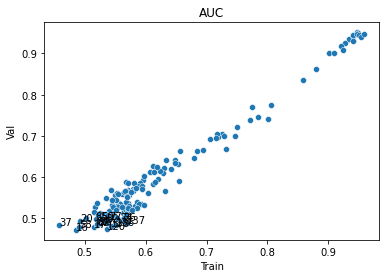

In [28]:
show_pt = lambda x, y: True
plt, cor = rfbf.view_outliers(vgg_lookup['train'], vgg_lookup['val'], do_show_flr_ix=lambda x, y: y < .5, meta_key='auc')
print(cor)
plt